In [1]:
using POMDPs
using POMDPModelTools
using Distributions
using POMDPPolicies  # For random policy, you might need different packages for other policies like POMCP
using POMDPSimulators
using POMDPModels
using BeliefUpdaters
using Printf
using FIB
using POMDPSimulators
using POMDPPolicies
using Plots
using POMDPs, POMDPModels, POMDPSimulators, BasicPOMCP
using PointBasedValueIteration
using ARDESPOT
using POMDPs
using POMCPOW
using POMDPModels
using POMDPTools
using POMDPs
using SARSOP
using POMDPModels

In [2]:
struct driveState
    h::Int
    r::Int
    z::Int
    phi::Int
end

In [3]:
struct driveObservation
    h::Int
    r::Int
    a::Int
end

In [4]:
# return probability of action = "stop"
function human_policy(h, r,  z)
    if h != 0 || r !=0 # maybe the not equal operation is not working here
        return 0.5
    elseif z == 0
        return 0.9
    else
        return 0.1
    end
end


human_policy (generic function with 1 method)

In [5]:
m = human_policy(1,0,0)
println(m)

0.5


In [6]:
# return updated z
function human_dynamics(h, r, z, phi)
    if phi == 0
        return z
    else
        if h == 0 || r == 0
            return 0
        else
            return z
        end
    end
end

human_dynamics (generic function with 1 method)

In [7]:
h_test = 0
r_test = 0
z_test = 1
phi_test = 0
z_up_test = human_dynamics(h_test, r_test, z_test, phi_test)
print("z_updated ")
println(z_up_test)
hp_test = human_policy(h_test, r_test, z_up_test)
print("p_stop ")
println(hp_test) 

z_updated 1
p_stop 0.1


In [8]:
struct drivePOMDP <: POMDP{driveState, Int, driveObservation} # POMDP{State, Action, Observation}
    discount_factor::Float64 # discount 
end

In [9]:
drivePOMDP() = drivePOMDP(0.95)

drivePOMDP

In [10]:
s = driveState[] # initialize an array of GridWorldStates
    

driveState[]

In [11]:
for phi = 0:1, z = 0:1, y = 0:1, x = 0:1
    push!(s, driveState(x,y,z,phi))
end

In [12]:
println(s[14])

driveState(1, 0, 1, 1)


In [13]:
POMDPs.states(pomdp::drivePOMDP) = s

In [14]:
mdp_2 = drivePOMDP() 

drivePOMDP(0.95)

In [15]:
s_space = states(mdp_2)

16-element Vector{driveState}:
 driveState(0, 0, 0, 0)
 driveState(1, 0, 0, 0)
 driveState(0, 1, 0, 0)
 driveState(1, 1, 0, 0)
 driveState(0, 0, 1, 0)
 driveState(1, 0, 1, 0)
 driveState(0, 1, 1, 0)
 driveState(1, 1, 1, 0)
 driveState(0, 0, 0, 1)
 driveState(1, 0, 0, 1)
 driveState(0, 1, 0, 1)
 driveState(1, 1, 0, 1)
 driveState(0, 0, 1, 1)
 driveState(1, 0, 1, 1)
 driveState(0, 1, 1, 1)
 driveState(1, 1, 1, 1)

In [16]:
function POMDPs.stateindex(pomdp::drivePOMDP, state::driveState)  
    idx = 1 + state.h*(2^0) + state.r*(2^1) + state.z*(2^2)+ state.phi*(2^3) # check if idx is being correctly returned
    return idx 
end

In [17]:
num = stateindex(mdp_2,  driveState(0, 0, 1, 0))

5

In [18]:
POMDPs.actions(pomdp::drivePOMDP) = [0, 1]

In [19]:
j_1 = actions(mdp_2)

2-element Vector{Int64}:
 0
 1

In [20]:
print(j_1)

[0, 1]

In [21]:
function POMDPs.actionindex(pomdp::drivePOMDP, act::Int64)
    if act==0
        return 1
    elseif act==1
        return 2
    end
end

In [22]:
m_1 = actionindex(mdp_2, 0)

1

In [23]:
function POMDPs.observations(pomdp::drivePOMDP)
    s = driveObservation[] 
    for h = 0:1, r = 0:1, a = 0:1
        push!(s,driveObservation(h,r,a))
    end
    return s
end

In [24]:
ob_space = observations(mdp_2)

8-element Vector{driveObservation}:
 driveObservation(0, 0, 0)
 driveObservation(0, 0, 1)
 driveObservation(0, 1, 0)
 driveObservation(0, 1, 1)
 driveObservation(1, 0, 0)
 driveObservation(1, 0, 1)
 driveObservation(1, 1, 0)
 driveObservation(1, 1, 1)

In [25]:
function POMDPs.obsindex(pomdp::drivePOMDP, o::driveObservation)
    idx = 1 + o.h*(2^0) + o.r*(2^1) + o.a*(2^2)
    return idx 
end

In [26]:
obs_idx = obsindex(mdp_2, driveObservation(1,1,1))

8

In [27]:
function POMDPs.reward(pomdp::drivePOMDP, state::driveState, act::Int64)
    h = state.h
    r = state.r
    if h == 0 && r == 0
        rwd = 0
    elseif h == 1 && r == 0
        rwd = -3
    elseif h == 1 && r == 1
        rwd = -10
    elseif h == 0 && r == 1
        rwd = +5
    else
        rwd = 0
    end
    return rwd
end

In [28]:
rwd = reward(mdp_2, driveState(1,1,0,1), 0)

-10

In [29]:
function POMDPs.observation(pomdp::drivePOMDP, act::Int64, state::driveState)
    h, r, z, phi = state.h, state.r, state.z, state.phi
    a = act
    p_stop = human_policy(h, r, z)
    # If the action to stop is taken by the robot, the human stops at a probability of p_stop this distribution needs to be returned for both stop action and go action.
    if a == 0
        if r == 0 && h == 0
            return SparseCat([driveObservation(0,0,a), driveObservation(1,0,a)], [p_stop, 1-p_stop])
        else
            return Deterministic(driveObservation(0,0,0))
        end
    elseif a == 1
        if r  == 0 && h == 0
            return SparseCat([driveObservation(0,1,a), driveObservation(1,1,a)], [p_stop, 1-p_stop])
        else
            return Deterministic(driveObservation(0,0,0))
        end
    else
        return Deterministic(driveObservation(0,0,0))
    end
end

In [30]:
obsdist = observation(mdp_2,1, driveState(0,0,1,1))

                                       SparseCat distribution           
                             ┌                                        ┐ 
   driveObservation(0, 1, 1) ┤■■■■ 0.1                                  
   driveObservation(1, 1, 1) ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.9   
                             └                                        ┘ 

In [31]:
function POMDPs.transition(pomdp::drivePOMDP, state::driveState, act::Int64)
    h, r, z, phi = state.h, state.r, state.z, state.phi
    a = act
    p_stop = human_policy(h, r, z)
    z = human_dynamics(h,r,z,phi)

    # reset the game
    if h > 0 || r > 0
        return Deterministic(driveState(0,0,z,phi))
    elseif h == 0 && r == 0
        if a == 0
            return SparseCat([driveState(0,0,z,phi), driveState(1,0,z,phi)], [p_stop, 1-p_stop])
        elseif a == 1
            return SparseCat([driveState(0,1,z,phi), driveState(1,1,z,phi)], [p_stop, 1-p_stop])
        else
            return Deterministic(driveState(0,0,z,phi))
        end
    else
        return Deterministic(driveState(0,0,z,phi))
    end
end

In [32]:
trans_test = transition(mdp_2, driveState(0,0,1,1),0)

                                    SparseCat distribution           
                          ┌                                        ┐ 
   driveState(0, 0, 0, 1) ┤■■■■ 0.1                                  
   driveState(1, 0, 0, 1) ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.9   
                          └                                        ┘ 

In [33]:
POMDPs.initialstate(pomdp::drivePOMDP) = SparseCat([(driveState(0, 0, 1, 1)), driveState(0,0,1,0)], [1, 0.0])
POMDPs.discount(pomdp::drivePOMDP) = pomdp.discount_factor
mdp_3 = drivePOMDP()

drivePOMDP(0.95)

In [55]:
function plot_data(h, r, rwd, plot_title)
    # Ensure h, r, and rwd are of the same length
    min_length = min(length(h), length(r), length(rwd))
    h, r, rwd = h[1:min_length], r[1:min_length], rwd[1:min_length]

    # Filter data
    indices_to_keep = [1]  # Always keep the first instance
    for i in 2:length(h)
        if !(h[i] == 0 && r[i] == 0)
            push!(indices_to_keep, i)
        end
    end
    h_filtered, r_filtered, rwd_filtered = h[indices_to_keep], r[indices_to_keep], rwd[indices_to_keep]

    # Create subplots with scatter points
    p1 = plot(h_filtered, label="h", title="h and r Plot")
    scatter!(p1, h_filtered, label="h points")
    plot!(p1, r_filtered, label="r")
    scatter!(p1, r_filtered, label="r points")

    p2 = plot(rwd_filtered, label="rwd", title="rwd Plot")
    scatter!(p2, rwd_filtered, label="rwd points")

    cum_rwd = cumsum(rwd_filtered)
    p3 = plot(cum_rwd, label="Cumulative rwd", title="Cumulative Sum of rwd")
    scatter!(p3, cum_rwd, label="Cumulative rwd points")

    # Combine plots into one figure with a main title
    combined_plot = plot(p1, p2, p3, layout=(1, 3), size=(1800, 600), title=plot_title)

    # Display the plot
    display(combined_plot)
end


plot_data (generic function with 2 methods)

In [56]:
pbvi_solver = PBVISolver()
pbvi_policy = solve(pbvi_solver, mdp_3)
human_pos = []
robot_pos = []
reward_pos = []

Any[]

In [57]:
for (s, a, r) in stepthrough(mdp_3, pbvi_policy, "s, a, r", max_steps=30)
    @show s
    @show a
    @show r
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

s = driveState(0, 0, 1, 1)
a = 0
r = 0
s = driveState(1, 0, 0, 1)
a = 1
r = -3
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 1)
a = 0
r = 5
s = driveState(0, 0, 0, 1)
a = 1
r = 0
s = driveState(0, 1, 0, 

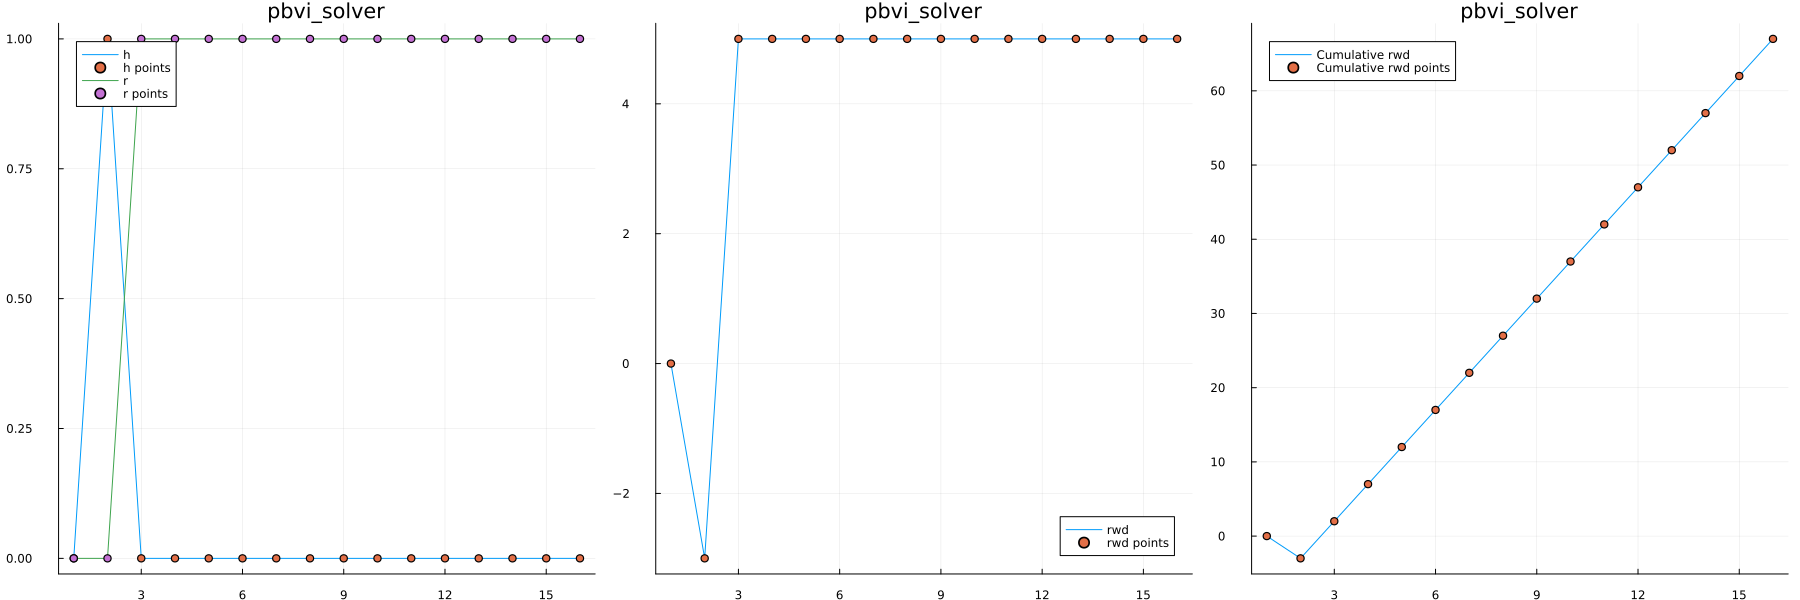

In [58]:
plot_title = "pbvi_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

In [61]:
human_pos = []
robot_pos = []
reward_pos = []
solver = SARSOPSolver()
sarsop_policy = solve(solver, mdp_3)
for (s, a, r) in stepthrough(mdp_3, sarsop_policy, "s, a, r", max_steps=30)
    @show s
    @show a
    @show r
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

Generating a pomdpx file: model.pomdpx

Loading the model ...
  input file   : model.pomdpx
  loading time : 0.00s 

SARSOP initializing ...
  initialization time : 0.00s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0       0       0        22.7024    28.3746    5.67215     2        1        
 0       0       1        28.3744    28.3746    0.000150279 3        2        
-------------------------------------------------------------------------------

SARSOP finishing ...
  target precision reached
  target precision  : 0.001000
  precision reached : 0.000150 

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-----------------------------------------------------------------------------

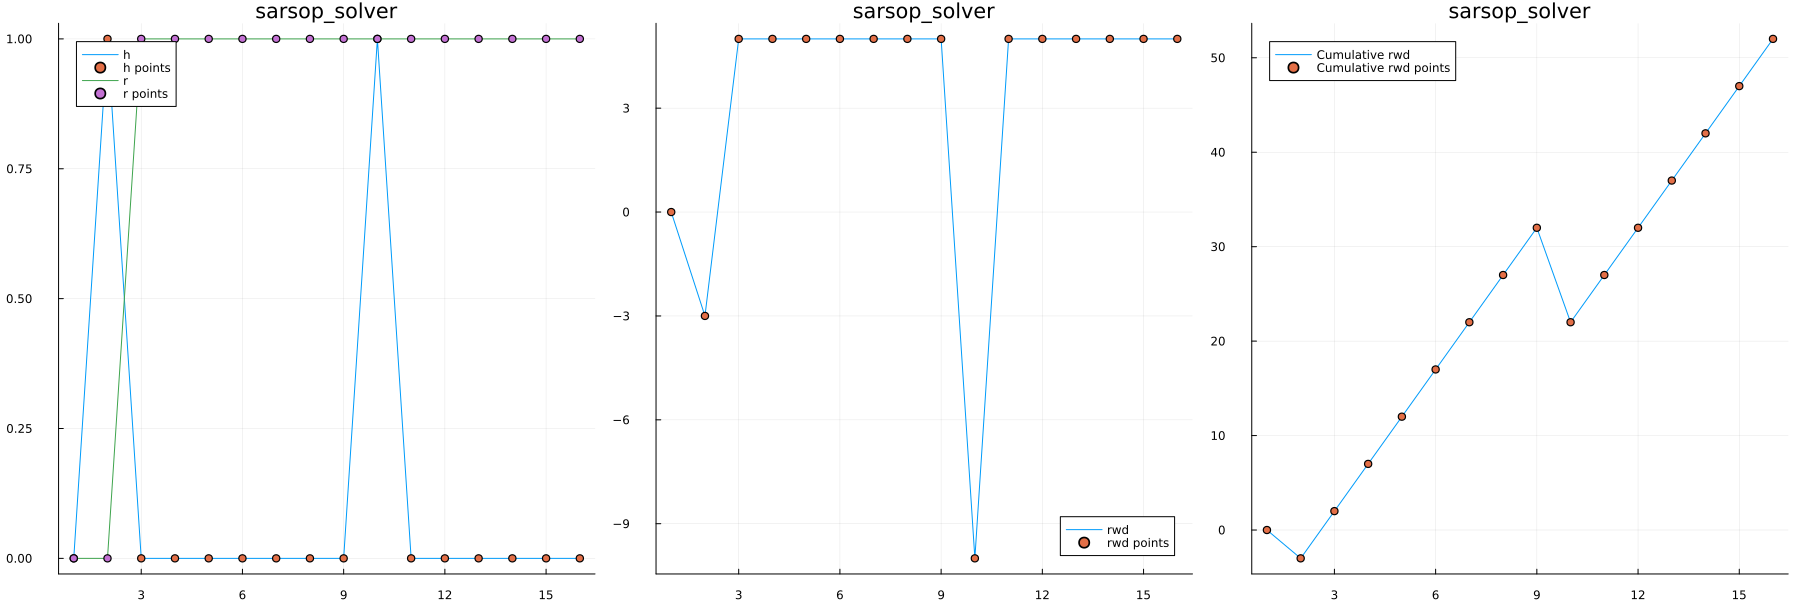

In [62]:
plot_title = "sarsop_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

In [63]:
human_pos = []
robot_pos = []
reward_pos = []
solver = DESPOTSolver(bounds=(-30.0, 30.0))
despot_planner = solve(solver, mdp_3)
for (s, a, o, r) in stepthrough(mdp_3, despot_planner, "s,a,o,r", max_steps=30)
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

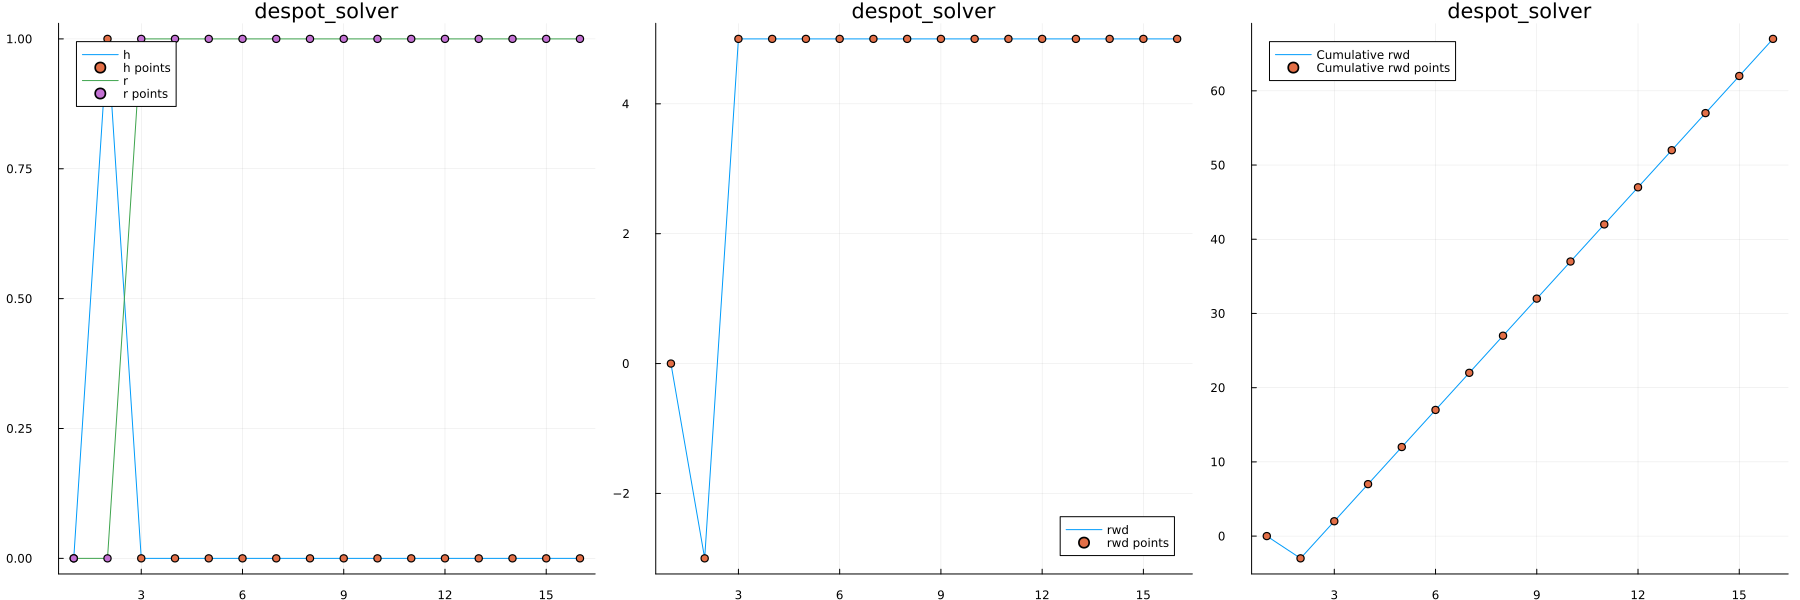

In [64]:
plot_title = "despot_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

In [69]:
human_pos = []
robot_pos = []
reward_pos = []

solver = POMCPOWSolver(criterion=MaxUCB(20.0))
pomcpow_planner = solve(solver, mdp_3)

for (s, a, o, r) in stepthrough(mdp_3, pomcpow_planner, "s,a,o,r", max_steps=30)
    push!(human_pos, s.h)
    push!(robot_pos, s.r)
    push!(reward_pos, r)
end

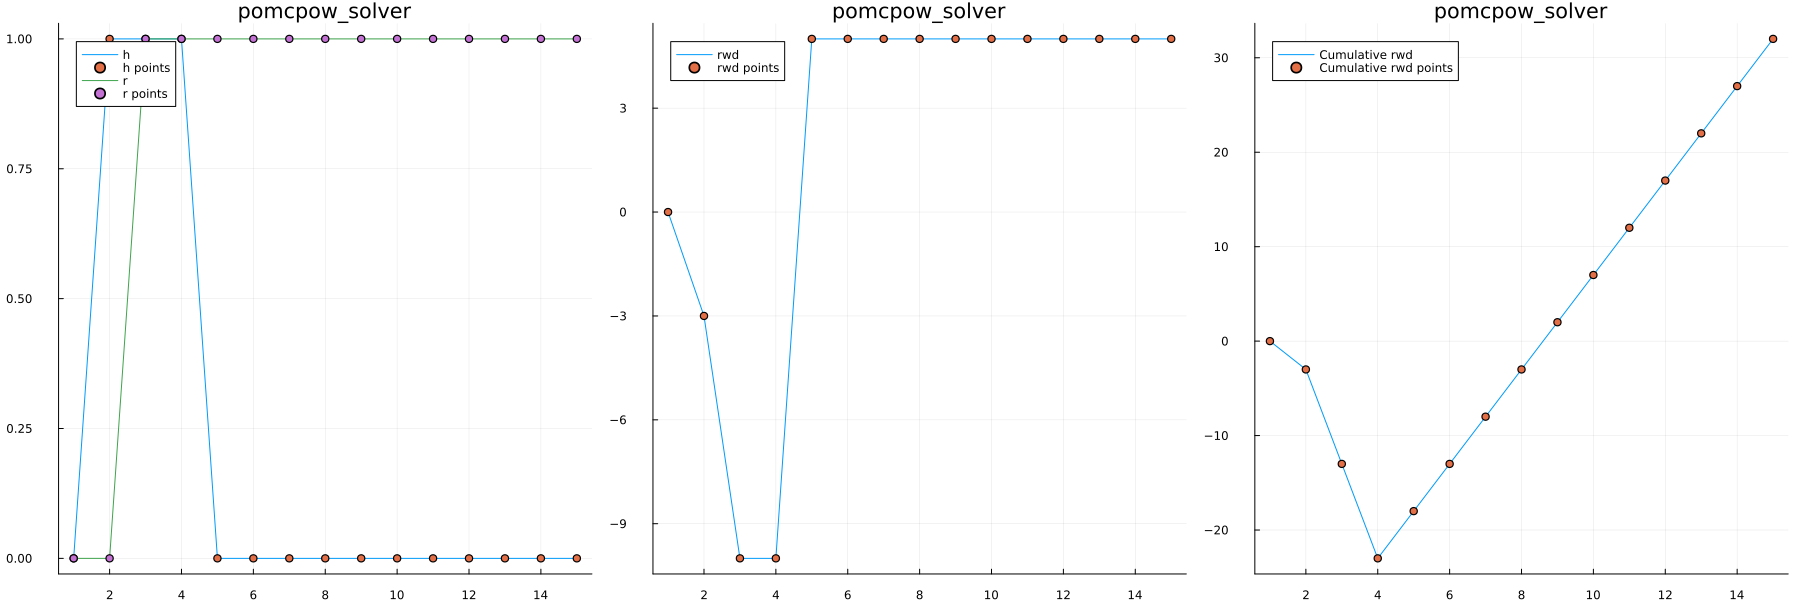

In [70]:
plot_title = "pomcpow_solver"
plot_data(human_pos, robot_pos, reward_pos, plot_title)

In [ ]:
# Create and run the rollout simulator
rollout_sim = RolloutSimulator(max_steps=10);
pbvi_reward = simulate(rollout_sim, mdp_3, pbvi_policy);
rand_reward = simulate(rollout_sim, mdp_3, rand_policy);
@show pbvi_reward;
@show rand_reward;